# Plot interpolation results

In [286]:
%load_ext nb_black

import scdiffeq_analyses as sdq_an
import glob, os
import pandas as pd
import seaborn as sns
import numpy as np

metrics_base_path = "./scDiffEq.task_one.timepoint_recovery.seed_{}/version_0/fit_logs/version_0/metrics.csv"
Metrics = {seed: pd.read_csv(metrics_base_path.format(seed)) for seed in range(5)}
BestTrainTest = {}
for seed, metrics_df in Metrics.items():
    BestTrainTest[seed] = {}
    task_one = sdq_an.TaskOneSummary(metrics_df)
    BestTrainTest[seed]["train"] = task_one.best_train_loss
    BestTrainTest[seed]["test"] = task_one.best_test_loss

best_sdq = pd.DataFrame(BestTrainTest).T
print(best_sdq.mean())
best_sdq

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black
train    13.748313
test     24.556157
dtype: float64


,train,test
0,13.113493,24.334347
1,13.892048,24.157946
2,13.807034,25.201881
3,13.941353,24.506296
4,13.987637,24.580315


<IPython.core.display.Javascript object>

In [287]:
best_prescient = pd.read_csv(
    "../../notebooks/task_2_nbs/folder_09_prescient/PRESCIENT.interpolation.no_weights.results.csv",
    index_col=0,
    names=["test", "train"],
    skiprows=1,
)[["train", "test"]]
print(best_prescient.mean())
best_prescient

train    14.944709
test     25.845095
dtype: float64


,train,test
0,15.265286,26.038500
1,14.392807,25.847347
2,14.809107,25.358963
3,15.089598,26.003586
4,15.166747,25.977081


<IPython.core.display.Javascript object>

In [288]:
train_df = pd.DataFrame(
    {"PRESCIENT": best_prescient["train"], "scDiffEq": best_sdq["train"]}
)
test_df = pd.DataFrame(
    {"PRESCIENT": best_prescient["test"], "scDiffEq": best_sdq["test"]}
)

<IPython.core.display.Javascript object>

In [321]:
import matplotlib.pyplot as plt
from scdiffeq.core.utils import AutoParseBase


class StyledBoxPlot(AutoParseBase):
    def __init__(
        self,
        figsize=None,
        figsize_height=1,
        figsize_width=1,
        box_face_zorder=7,
        box_edge_zorder=8,
        scatter_zorder=10,
        lw=0.5,
        widths=0.5,
    ):
        self.__parse__(locals())
        self.build_plot()

    def __configure__(self, data):

        self.columns = data.columns.tolist()

    def build_plot(self):

        self.fig, self.axes = vinplots.quick_plot(
            nplots=2,
            ncols=2,
            figsize=self.figsize,
            figsize_height=self.figsize_height,
            figsize_width=self.figsize_width,
            wspace=0.4,
        )

    def scatter(
        self, ax, x: float, y: pd.Series, w_scale: float = 0.02, **scatter_kwargs
    ):

        n_pts = y.shape[0]
        x = np.random.normal(loc=x, scale=w_scale, size=n_pts)

        ax.scatter(x, y, edgecolor="None", **scatter_kwargs)

    def run_scatter(self, ax, alpha=0.8):

        for i in range(len(self.columns)):
            self.scatter(
                ax,
                x=i + 1,
                y=self.data[self.columns[i]],
                c=self.colors[i],
                zorder=self.scatter_zorder,
                alpha=alpha,
                s=35,
            )

    def _whisker_cap_colors(self):
        for color in self.colors:
            for c in [color] * 2:
                yield c

    @property
    def whisker_cap_colors(self):
        return list(self._whisker_cap_colors())

    def _edge_box(self, ax):
        box_edges = ax.boxplot(
            self.data.values,
            patch_artist=True,
            showmeans=True,
            meanline=True,
            showfliers=False,
            widths=self.widths,
            zorder=self.box_edge_zorder,
        )

        for n, patch in enumerate(box_edges["whiskers"]):
            patch.set_c(self.whisker_cap_colors[n])
            patch.set_linewidth(self.lw)
        for n, patch in enumerate(box_edges["caps"]):
            patch.set_c(self.whisker_cap_colors[n])
            patch.set_linewidth(self.lw)

        for n, box_mean in enumerate(box_edges["means"]):
            box_mean.set_color(self.colors[n])
            box_mean.set_linestyle("--")
            box_mean.set_linewidth(self.lw * 2)
        for box_median in box_edges["medians"]:
            box_median.set_visible(False)
        for n, box_edge in enumerate(box_edges["boxes"]):
            box_edge.set_facecolor([0, 0, 0, 0])
            box_edge.set_edgecolor(self.colors[n])  #
            box_edge.set_linewidth(self.lw)

    def run_boxplot(self, ax, alpha=0.3):

        box = ax.boxplot(
            self.data.values,
            showmeans=False,
            meanline=False,
            widths=self.widths,
            labels=self.columns,
            patch_artist=True,
            showfliers=False,
            zorder=self.box_face_zorder,
        )
        ax.set_xticks([])

        for patch in box["whiskers"]:
            patch.set_visible(False)
        for patch in box["caps"]:
            patch.set_visible(False)

        for patch in box["medians"]:
            patch.set_visible(False)

        for n, patch in enumerate(box["boxes"]):
            patch.set_facecolor(self.colors[n])
            patch.set_alpha(alpha)

        self._edge_box(ax)

    def __call__(self, ax, data):

        self.data = data

        #         self.colors = ["olivedrab", "dodgerblue", "salmon", "goldenrod"]
        self.colors = ["#fb8500", "#023047"]
        self.__configure__(data)
        self.run_scatter(ax=ax)
        self.run_boxplot(ax=ax)

<IPython.core.display.Javascript object>

### Plot

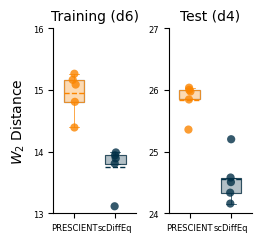

<IPython.core.display.Javascript object>

In [324]:
sbp = StyledBoxPlot(figsize_width=0.2, figsize_height=0.5)
sbp(ax=sbp.axes[0], data=train_df)
sbp(ax=sbp.axes[1], data=test_df)
sbp.axes[0].set_ylim(13, 16)
sbp.axes[1].set_ylim(24, 27)

xt = sbp.axes[0].set_xticks(range(1, 3), ["PRESCIENT", "scDiffEq"], fontsize=6)
xt = sbp.axes[1].set_xticks(range(1, 3), ["PRESCIENT", "scDiffEq"], fontsize=6)
yt = sbp.axes[0].set_yticks(range(13, 17), range(13, 17), fontsize=6)
yt = sbp.axes[1].set_yticks(range(24, 28), range(24, 28), fontsize=6)

ti = sbp.axes[0].set_title("Training (d6)", fontsize=10)
ti = sbp.axes[1].set_title("Test (d4)", fontsize=10)
yl = sbp.axes[0].set_ylabel("$W_{2}$ Distance")
plt.savefig("task_one.interpolation.results.svg")